## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu',
                                   name='hidden_layer'+str(i+1))(x)
            x = BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.3, 0.9]
redice_lr_patient = [10, 15, 20]

In [9]:
import itertools
from keras.callbacks import ReduceLROnPlateau

results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 10
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________


Epoch 11/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3128 - accuracy: 0.5430 - val_loss: 1.4837 - val_accuracy: 0.4737
Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2875 - accuracy: 0.5529 - val_loss: 1.4737 - val_accuracy: 0.4851
Epoch 13/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2657 - accuracy: 0.5614 - val_loss: 1.4753 - val_accuracy: 0.4840
Epoch 14/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2429 - accuracy: 0.5687 - val_loss: 1.4617 - val_accuracy: 0.4840
Epoch 15/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2207 - accuracy: 0.5797 - val_loss: 1.4633 - val_accuracy: 0.4873
Epoch 16/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2013 - accuracy: 0.5848 - val_loss: 1.4580 - val_accuracy: 0.4881
Epoch 17/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1810 - accuracy: 0.5936 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 51us/step - loss: 2.2472 - accuracy: 0.2647 - val_loss: 2.1953 - val_accuracy: 0.1533
Epoch 2/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.7589 - accuracy: 0.3848 - val_loss: 2.0149 - val_accuracy: 0.2634
Epoch 3/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.6341 - accuracy: 0.4279 - val_loss: 1.8563 - val_accuracy: 0.3481
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5614 - accuracy: 0.4517 - val_loss: 1.7546 - val_accuracy: 0.3783
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5075 - accuracy: 0.4698 - val_loss: 1.6593 - val_accuracy: 0.4175
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4648 - accuracy: 0.4849 - val_loss: 1.5981 - val_accuracy: 0.4362
Epoch 7/25
50000/50000 [==============================] - 2s 48us/st

Epoch 21/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.1078 - accuracy: 0.6179 - val_loss: 1.4473 - val_accuracy: 0.4871
Epoch 22/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.0916 - accuracy: 0.6237 - val_loss: 1.4596 - val_accuracy: 0.4849
Epoch 23/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.0748 - accuracy: 0.6307 - val_loss: 1.4505 - val_accuracy: 0.4882
Epoch 24/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.0571 - accuracy: 0.6377 - val_loss: 1.4482 - val_accuracy: 0.4923
Epoch 25/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.0397 - accuracy: 0.6437 - val_loss: 1.4464 - val_accuracy: 0.4922
Numbers of exp: 5, reduce_factor: 0.30, reduce_patient: 20
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)           

Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4569 - accuracy: 0.4905 - val_loss: 1.5856 - val_accuracy: 0.4410
Epoch 7/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4207 - accuracy: 0.5027 - val_loss: 1.5405 - val_accuracy: 0.4540
Epoch 8/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3893 - accuracy: 0.5147 - val_loss: 1.5301 - val_accuracy: 0.4529
Epoch 9/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3605 - accuracy: 0.5249 - val_loss: 1.5057 - val_accuracy: 0.4667
Epoch 10/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.3318 - accuracy: 0.5347 - val_loss: 1.5079 - val_accuracy: 0.4647
Epoch 11/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.3083 - accuracy: 0.5454 - val_loss: 1.4995 - val_accuracy: 0.4689
Epoch 12/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.2848 - accuracy: 0.5542 - val_loss

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 53us/step - loss: 2.2823 - accuracy: 0.2623 - val_loss: 2.1126 - val_accuracy: 0.2226
Epoch 2/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.7724 - accuracy: 0.3856 - val_loss: 1.9675 - val_accuracy: 0.3115
Epoch 3/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.6445 - accuracy: 0.4286 - val_loss: 1.8375 - val_accuracy: 0.3734
Epoch 4/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5734 - accuracy: 0.4509 - val_loss: 1.7263 - val_accuracy: 0.4066
Epoch 5/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.5230 - accuracy: 0.4674 - val_loss: 1.6482 - val_accuracy: 0.4258
Epoch 6/25
50000/50000 [==============================] - 2s 45us/step - loss: 1.4752 - accuracy: 0.4872 - val_loss: 1.6001 - val_accuracy: 0.4406
Epoch 7/25
50000/50000 [==============================] - 2s 45us/st

50000/50000 [==============================] - 3s 51us/step - loss: 0.5067 - accuracy: 0.8486 - val_loss: 1.4242 - val_accuracy: 0.5434
Epoch 21/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.4957 - accuracy: 0.8540 - val_loss: 1.4216 - val_accuracy: 0.5411
Epoch 22/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.4860 - accuracy: 0.8576 - val_loss: 1.4552 - val_accuracy: 0.5437
Epoch 23/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.4773 - accuracy: 0.8611 - val_loss: 1.4548 - val_accuracy: 0.5419
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.4683 - accuracy: 0.8639 - val_loss: 1.4552 - val_accuracy: 0.5354
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.4581 - accuracy: 0.8682 - val_loss: 1.4633 - val_accuracy: 0.5450
Numbers of exp: 10, reduce_factor: 0.10, reduce_patient: 15
Model: "model_12"
______________________________________________

Epoch 5/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.2886 - accuracy: 0.5495 - val_loss: 1.5848 - val_accuracy: 0.4377
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2388 - accuracy: 0.5702 - val_loss: 1.4930 - val_accuracy: 0.4674
Epoch 7/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1977 - accuracy: 0.5843 - val_loss: 1.4699 - val_accuracy: 0.4803
Epoch 8/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1586 - accuracy: 0.6000 - val_loss: 1.4705 - val_accuracy: 0.4775
Epoch 9/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.1223 - accuracy: 0.6122 - val_loss: 1.4959 - val_accuracy: 0.4677
Epoch 10/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.0910 - accuracy: 0.6256 - val_loss: 1.4389 - val_accuracy: 0.4888
Epoch 11/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0602 - accuracy: 0.6375 - val_loss:

50000/50000 [==============================] - 3s 51us/step - loss: 0.7404 - accuracy: 0.7655 - val_loss: 1.3901 - val_accuracy: 0.5286
Epoch 25/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.7328 - accuracy: 0.7700 - val_loss: 1.4062 - val_accuracy: 0.5219
Numbers of exp: 13, reduce_factor: 0.30, reduce_patient: 15
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_43 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
____________________________________________

Epoch 9/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.3194 - accuracy: 0.5434 - val_loss: 1.4996 - val_accuracy: 0.4726
Epoch 10/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2982 - accuracy: 0.5500 - val_loss: 1.4844 - val_accuracy: 0.4707
Epoch 11/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2779 - accuracy: 0.5577 - val_loss: 1.4770 - val_accuracy: 0.4787
Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2579 - accuracy: 0.5662 - val_loss: 1.4925 - val_accuracy: 0.4744
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2404 - accuracy: 0.5708 - val_loss: 1.4634 - val_accuracy: 0.4831
Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.2228 - accuracy: 0.5789 - val_loss: 1.4640 - val_accuracy: 0.4807
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2078 - accuracy: 0.5831 - val_l

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 63us/step - loss: 2.0081 - accuracy: 0.3267 - val_loss: 2.1314 - val_accuracy: 0.2002
Epoch 2/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.6324 - accuracy: 0.4305 - val_loss: 1.9599 - val_accuracy: 0.2872
Epoch 3/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.5312 - accuracy: 0.4673 - val_loss: 1.7835 - val_accuracy: 0.3881
Epoch 4/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.4732 - accuracy: 0.4861 - val_loss: 1.6602 - val_accuracy: 0.4216
Epoch 5/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.4248 - accuracy: 0.5020 - val_loss: 1.5927 - val_accuracy: 0.4457
Epoch 6/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.3866 - accuracy: 0.5154 - val_loss: 1.5511 - val_accuracy: 0.4530
Epoch 7/25
50000/50000 [==============================] - 3s 56us/st

Epoch 21/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1209 - accuracy: 0.6168 - val_loss: 1.4573 - val_accuracy: 0.4925
Epoch 22/25
50000/50000 [==============================] - 3s 56us/step - loss: 1.1103 - accuracy: 0.6201 - val_loss: 1.4516 - val_accuracy: 0.4962
Epoch 23/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.0974 - accuracy: 0.6252 - val_loss: 1.4415 - val_accuracy: 0.4949
Epoch 24/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0859 - accuracy: 0.6303 - val_loss: 1.4391 - val_accuracy: 0.4981
Epoch 25/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0743 - accuracy: 0.6338 - val_loss: 1.4342 - val_accuracy: 0.5001
Numbers of exp: 18, reduce_factor: 0.10, reduce_patient: 10
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)         

50000/50000 [==============================] - 3s 55us/step - loss: 1.4206 - accuracy: 0.5017 - val_loss: 1.6362 - val_accuracy: 0.4187
Epoch 6/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3687 - accuracy: 0.5215 - val_loss: 1.5656 - val_accuracy: 0.4520
Epoch 7/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.3280 - accuracy: 0.5363 - val_loss: 1.5820 - val_accuracy: 0.4394
Epoch 8/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2843 - accuracy: 0.5528 - val_loss: 1.5544 - val_accuracy: 0.4523
Epoch 9/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.2505 - accuracy: 0.5630 - val_loss: 1.5486 - val_accuracy: 0.4462
Epoch 10/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.2163 - accuracy: 0.5769 - val_loss: 1.5291 - val_accuracy: 0.4662
Epoch 11/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.1838 - accuracy: 0.5909 - val_loss: 1.5057 - v

50000/50000 [==============================] - 3s 52us/step - loss: 0.8834 - accuracy: 0.7045 - val_loss: 1.5179 - val_accuracy: 0.4824
Numbers of exp: 21, reduce_factor: 0.30, reduce_patient: 10
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_67 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_68 (Batc (None, 256)               1024      
____________________________________________________________

Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.2268 - accuracy: 0.5733 - val_loss: 1.4904 - val_accuracy: 0.4769
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1962 - accuracy: 0.5859 - val_loss: 1.6915 - val_accuracy: 0.4308
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1716 - accuracy: 0.5941 - val_loss: 1.5756 - val_accuracy: 0.4629
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1441 - accuracy: 0.6049 - val_loss: 1.4873 - val_accuracy: 0.4771
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.1171 - accuracy: 0.6159 - val_loss: 1.5893 - val_accuracy: 0.4583
Epoch 15/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0944 - accuracy: 0.6244 - val_loss: 1.5088 - val_accuracy: 0.4838
Epoch 16/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0703 - accuracy: 0.6322 - val_

Total params: 923,914
Trainable params: 922,378
Non-trainable params: 1,536
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.0022 - accuracy: 0.3192 - val_loss: 2.1481 - val_accuracy: 0.1918
Epoch 2/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.6744 - accuracy: 0.4165 - val_loss: 2.0002 - val_accuracy: 0.3102
Epoch 3/25
50000/50000 [==============================] - 3s 53us/step - loss: 1.5554 - accuracy: 0.4549 - val_loss: 1.8371 - val_accuracy: 0.3648
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4763 - accuracy: 0.4835 - val_loss: 1.7039 - val_accuracy: 0.4159
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4156 - accuracy: 0.5048 - val_loss: 1.6218 - val_accuracy: 0.4282
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - 

50000/50000 [==============================] - 3s 56us/step - loss: 1.0156 - accuracy: 0.6583 - val_loss: 1.5768 - val_accuracy: 0.4574
Epoch 20/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.9969 - accuracy: 0.6629 - val_loss: 1.5217 - val_accuracy: 0.4707
Epoch 21/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.9763 - accuracy: 0.6694 - val_loss: 1.4915 - val_accuracy: 0.4947
Epoch 22/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9577 - accuracy: 0.6779 - val_loss: 1.4963 - val_accuracy: 0.4766
Epoch 23/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9381 - accuracy: 0.6867 - val_loss: 1.5740 - val_accuracy: 0.4563
Epoch 24/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9198 - accuracy: 0.6943 - val_loss: 1.5106 - val_accuracy: 0.4806
Epoch 25/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9022 - accuracy: 0.6988 - val_loss: 1.5238

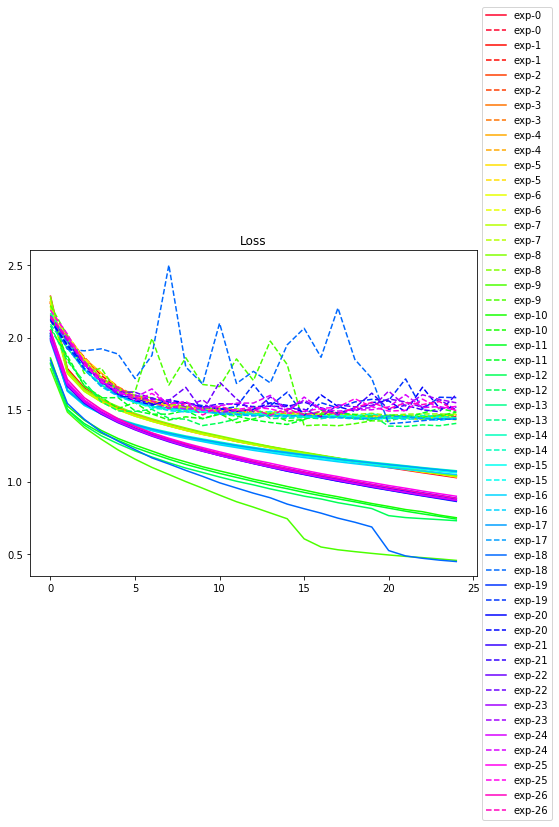

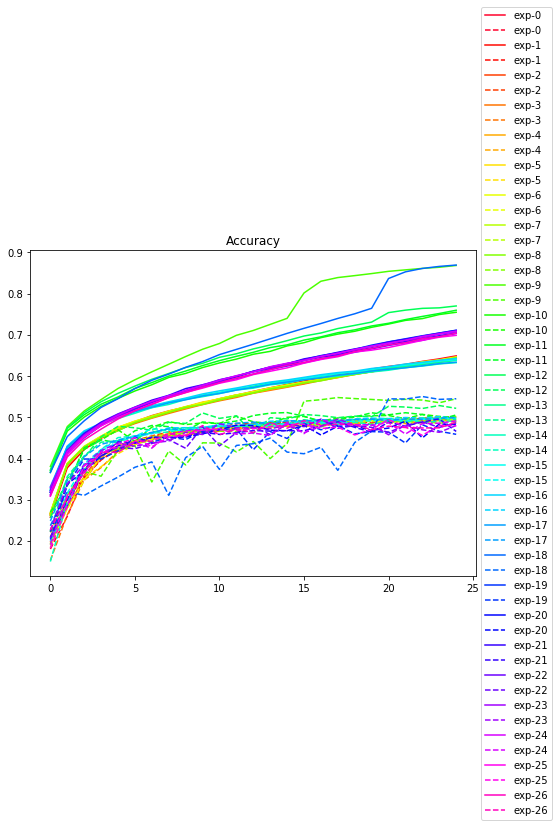

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()